In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd 'gdrive/MyDrive/Colab Notebooks/donees_fauxBilliet/'

/content/gdrive/MyDrive/Colab Notebooks/donees_fauxBilliet


Ma mission pour l’ONCFM (Organisation Nationale Anti-Contrefaçon) est de mettre en place un algorithme qui permettra d’identifier automatiquement les faux billets en euros en fonction de leurs dimensions et des éléments qui les composent.

Deux méthodes de prédiction sont ici en compétition :

Une régression logistique classique ;
une k-moyenne (dont les centroïdes seront utilisés pour effectuer la prédiction).

**Résumé :**


**I. Analyse exploratoire des données**

-- A. Description de l’ensemble de données

-- B. Traitement des valeurs manquantes à l’aide de la régression linéaire pour les prédire

---- a. Régression linéaire (statsmodel)  

---- b. Analyse des résultats

------ → Calcul des leviers

------ → Calcul des résidus étudiés

------ → Calcul de la distance de Cook

------ → Test de colinéarité des variables

------ → Test de l’homoscédasticité

------ → Test de normalité résiduelle

---- c. Prédiction et imputation des valeurs manquantes  

-- C. Analyse en composantes principales (ACP) sur les caractéristiques

---- a. Normalisation des données  

---- b. Rapport de variance expliqué et tracé des éboulis  

---- c. Cercles de corrélation et projections de points

-- D. Analyse univariée sur cible




**II. Régression logistique**

-- A. Mise en œuvre

-- B. Essais

-- C. Évaluation du modèle

---- a. Matrice de confusion  

---- b. Mesure de la qualité de la classification (courbe ROC)  

---- c. Optimisation





**III. Mise en œuvre de la fonction de test**

-- A. Préparation de l’échantillon  

-- B. Mise en œuvre de la fonction de test

-- C. Résultat du test (ici)



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import researchpy
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [4]:
def shapiro_test(x):
    '''
     Le test de Shapiro-Wilk teste l’hypothèse nulle selon laquelle les données ont été tirées d’une distribution normale.

Paramètres:
        x (array_like) : tableau d’échantillons de données

Retourne:
        statistique (float) : la statistique de test
        p-value (float) : la p-value pour le test d’hypothèse
    '''
    from scipy.stats import shapiro
    x1, pval1 = shapiro(x)

    print("="*100,"\n")
    print("Shapiro-Wilk test","\n")
    if pval1 < 0.05:
        print("pval1 < 0,05 ==> l’hypothèse nulle est rejetée (les résidus ne suivent pas une loi normale)")
    else:
        print("pval1 > 0,05 ==> On ne peut pas rejeter l’hypothèse nulle H0 (les résidus suivent une loi normale)")
    print()
    print("="*100,"\n")

def display_scree_plot(pca):
    '''
    Crée un scree plot associé aux composants principaux

Paramètres:
        PCA : le résultat de l’instantané de PCA dans scikit learn
    '''
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Principal components")
    plt.ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")
    plt.show(block=False)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''
    Afficher des cercles de corrélation, un pour chaque plan factoriel

Paramètres:
        pcs : model_pca.components
        n_comp (float) : le nombre de composants
        PCA : le résultat de l’instanciation de PCA dans Scikit Learn
        axis_rank (float) : le rang de l’axe à visualiser
        labels : libellés de nos variables
    '''
    # Pour chaque plan factoriel
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # Initialiser la figure matplotlib
            #fig, ax = plt.subplots(figsize=(8,8))

            #Déterminer les limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # Ajouter des flèches
            # S’il y a plus de 30 flèches, nous n’affichons pas le triangle à la fin
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:],
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            # Afficher les noms des variables
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            # afficher le cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            #  Afficher les noms des variables ...
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            #  Affichage des lignes de grille
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
              # Étiqueter les axes, avec le pourcentage de variance expliqué
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title(" Cercle de Correlation (on PC{} et PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''
    Afficher un nuage de points sur un plan factoriel, un pour chaque plan factoriel

Paramètres:
        X_projected : model_pca.transform(X_scaled)
        n_comp (float) : le nombre de composants
        PCA : le résultat de l’instanciation de PCA dans Scikit Learn
        axis_rank : le rang de l’axe à visualiser
        labels : libellés de nos variables
    '''

# Pour chaque plan factoriel
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # Initialize the matplotlib figure
            #fig = plt.figure(figsize=(7,6))

            # Afficher les points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # afficher les labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')

            # Définir les limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # Affichage des lignes de grille
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Étiqueter les axes, en expliquant le pourcentage de variance
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            #plt.show(block=False)
            plt.title("Projection des points (on PC{} et PC{})".format(d1+1, d2+1))

**I. Exploration du data**

**A.  Description du Dataset**

In [5]:
data = pd.read_csv('1-billets.csv', sep=";", decimal='.')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [6]:
data.shape

(1500, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


**note** :

- Nous disposons d’un jeu de données contenant les mesures géométriques de 1 500 billets :
→ 1 000 sont vrais et 500 sont faux
Une variable est booléenne : elle nous donne la nature du billet (Vrai ou Faux)
**Danger** :

- 37 valeurs sont manquantes dans la colonne
« margin_low » → Nous pouvons prédire les valeurs manquantes sur la variable « marge faible » en utilisant la régression linéaire (statsmodel)

**B. Traitement des données manquantes en utilisant la regression linéaire**

**a.  Regression Lineaire (statsmodel)**

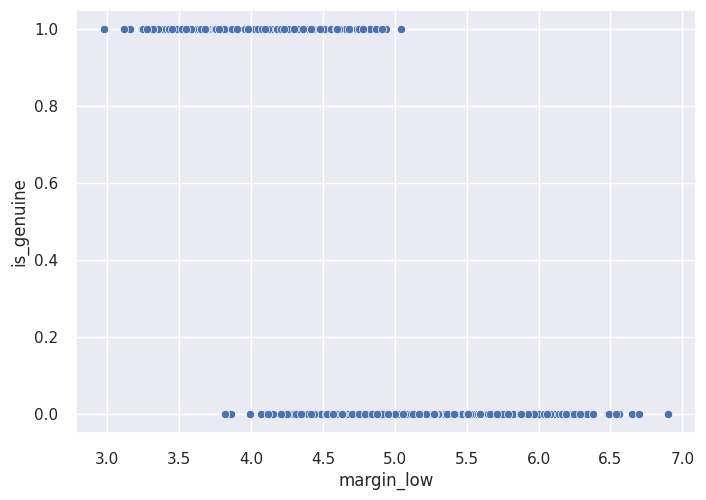

In [8]:
#  representation Graphique
sns.set()
ax = sns.scatterplot(x="margin_low", y="is_genuine", data=data)

**notes :**

- Au-delà d’un minimum de marge de 5, on remarque que les billets sont pour la plupart faux

**nb :**
- Nous décidons de supprimer la variable « is_genuine » pour éviter les fuites de données (ou une influence intempestive de cette variable sur nos résultats)

In [9]:
# Data preparation
df = data[['diagonal', 'height_left', 'height_right', 'margin_low',
           'margin_up', 'length']]

In [10]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length',
                    data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 16 Aug 2023   Prob (F-statistic):          2.60e-202
Time:                        14:44:30   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

**NOTE** :

Nous voyons ici que tous les paramètres sont significatifs et ont une valeur de p inférieure à 5%, le niveau de test attendu
Le R2 est d’environ 0,47, tout comme le R2 ajusté.

**b. analyse des resultats**

In [11]:
# Nous effectuerons les tests à un niveau α = 5%
alpha = 0.05

# Numbre d' individus
n = df['margin_low'].count()

# Numbre de variables
p = 6

analysis = pd.DataFrame({'obs':np.arange(1, n+1)})

- Calcul des leviers (atypicalité des variables explicatives) :

Nous considérons que le seuil des leviers est : 2∗𝑝𝑛

In [12]:
analysis['levers'] = reg_multi.get_influence().hat_matrix_diag
threshold_levers = 2*p/n

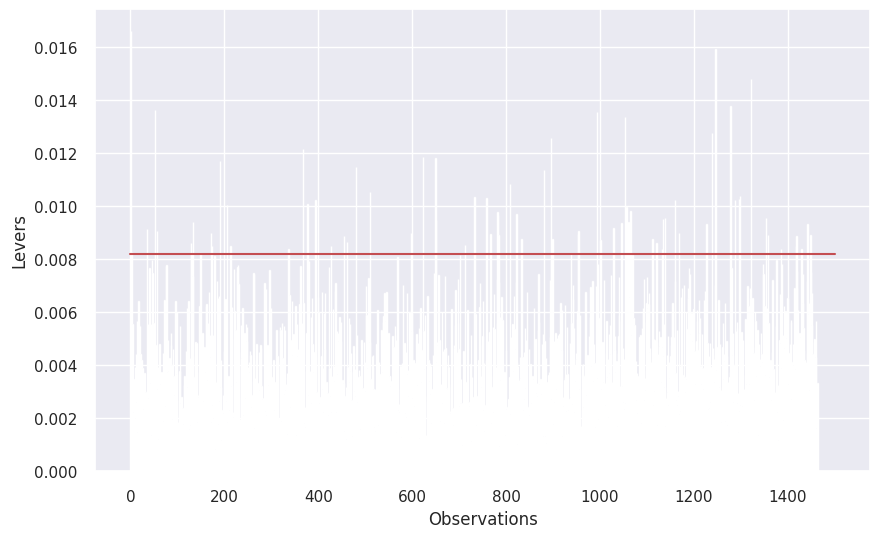

In [13]:
plt.figure(figsize=(10,6))
plt.bar(analysis['obs'], analysis['levers'])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel('Observations')
plt.ylabel('Levers')
plt.plot([0, 1500], [threshold_levers, threshold_levers], color='r')
plt.show()

In [14]:
# Sélection des points pour lesquels le levier est supérieur au seuil
lev_obs = analysis.loc[analysis['levers'] > threshold_levers, :]
print(lev_obs.head(),"\n")
print(len(lev_obs),"are upper than the threshold")

    obs    levers
0     1  0.016606
2     3  0.008298
34   35  0.009156
52   53  0.013635
56   57  0.009087 

75 are upper than the threshold


- Calcul des résidus étudiés (atypicalité de la variable à expliquer) :


Ici, nous avons n−p−1>30,
de sorte que le seuil pour les résidus d’étudiants suit approximativement une loi étudiante 𝑇(n−p−1)

In [15]:
analysis['rstudent'] = reg_multi.get_influence().resid_studentized_internal
rstudent_threshold = t.ppf(1-alpha/2,n-p-1)

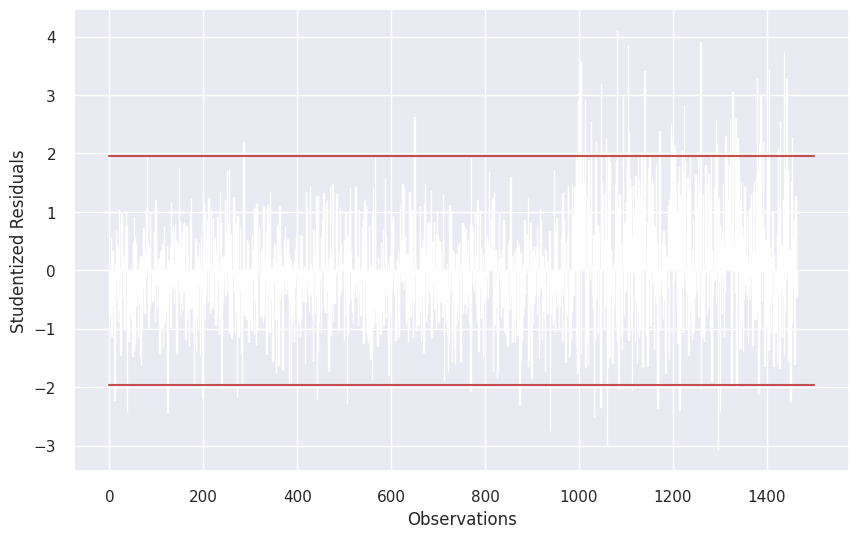

In [16]:
plt.figure(figsize=(10,6))
plt.bar(analysis["obs"], analysis["rstudent"])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel("Observations")
plt.ylabel("Studentized Residuals")
plt.plot([0, 1500], [rstudent_threshold, rstudent_threshold], color='r')
plt.plot([0, 1500], [-rstudent_threshold, -rstudent_threshold], color='r')
plt.show()

In [17]:
rstu_obs = analysis.loc[(analysis['rstudent'] > rstudent_threshold) & (analysis['rstudent'] > -rstudent_threshold)]
print(rstu_obs.head(),"\n")
print(len(rstu_obs),"sont supérieurs aux seuils")

     obs    levers  rstudent
285  286  0.007106  2.198945
564  565  0.004796  1.979045
649  650  0.011824  2.623086
993  994  0.013583  1.996766
998  999  0.005801  2.892652 

53 sont supérieurs aux seuils


- Calcul de la distance de COOK:

In [18]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est n-p.

In [19]:
analysis['dcooks'] = influence['cooks_d']
dcook_threshold = 3/(n-p)

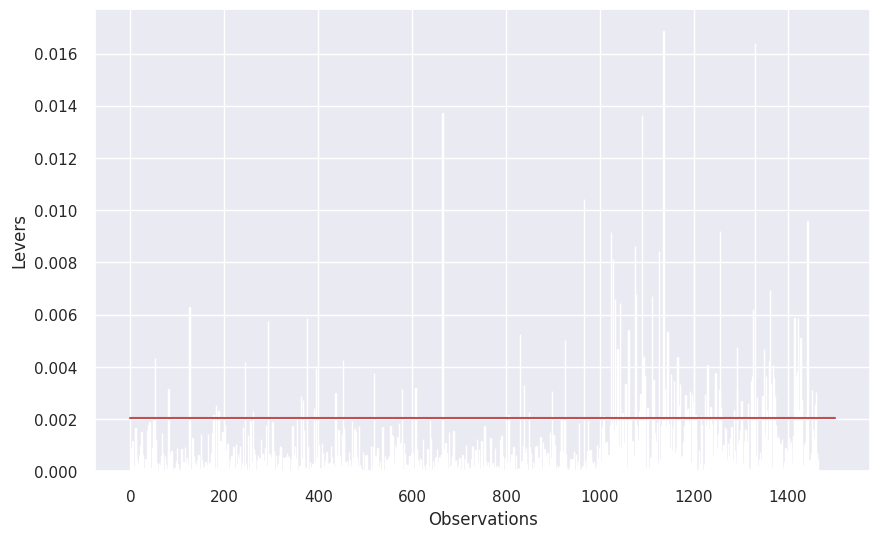

In [20]:
# Detection des observations influents
plt.figure(figsize=(10,6))
plt.bar(analysis['obs'], analysis['dcooks'])
plt.xticks(np.arange(0, 1500, step=200))
plt.xlabel('Observations')
plt.ylabel('Levers')
plt.plot([0, 1500], [dcook_threshold, dcook_threshold], color='r')
plt.show()

In [21]:
dcooks_obs = analysis.loc[(analysis['dcooks'] > dcook_threshold)]
print(dcooks_obs.head(),"\n")
print(len(dcooks_obs),"sont supérieurs aux seuils")

     obs    levers  rstudent    dcooks
52    53  0.013635 -1.372229  0.004338
80    81  0.003806  0.022997  0.003151
125  126  0.001589  0.172284  0.006308
176  177  0.002004 -0.622183  0.002176
182  183  0.002507  0.174186  0.002560 

118 sont supérieurs aux seuils


- **Test de la colinéarité**

In [22]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i)
 for i in np.arange(1,variables.shape[1])]

[1.013612899068628,
 1.1382605736082476,
 1.2301145155560345,
 1.4044037781843621,
 1.5769501453665853]

**note**:
- tous les coefiscients sont superieurs à 10 , il ya donc pas de colinéarité

- **Test d’homoscédasticité** :

In [23]:
# Tester la constance de la variance des résidus
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval,"\n")

if pval < 5/100:
    print("valeur < 5% , H0 est rejeté: les variances sont hétéroscédastiques (non constantes)")
else : print("pvalue > 5%, H0 ne peut pas être rejeté: les variances sont constantes (ou homoscédastiques)")

p value test Breusch Pagan: 7.7595352162878e-16 

valeur < 5% , H0 est rejeté: les variances sont hétéroscédastiques (non constantes)


- **Test de normalité résiduelle** :

In [24]:
shapiro_test(reg_multi.resid)


Shapiro-Wilk test 

pval1 < 0,05 ==> l’hypothèse nulle est rejetée (les résidus ne suivent pas une loi normale)




**note** :

- L’hypothèse du modèle linéaire n’est pas respectée : les résidus ne sont ni gaussiens ni homoscédastiques
- Mais compte tenu de la taille de notre échantillon (1500 individus), les résultats du modèle seront toujours viables

**c. Prédiction et imputation des valeurs manquantes**

In [25]:
# Prediction
df_na = df[df["margin_low"].isnull()]
predict_na = reg_multi.predict(df_na)

In [26]:
# Imputations
data["margin_low"][data["margin_low"].isnull()] = predict_na
df["margin_low"][df["margin_low"].isnull()] = predict_na

<ipython-input-26-0750ac3ef90a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["margin_low"][data["margin_low"].isnull()] = predict_na
<ipython-input-26-0750ac3ef90a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["margin_low"][df["margin_low"].isnull()] = predict_na


In [27]:
#final sheck
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


**C. Analyse en composantes principales (ACP) des caractéristiques**

**1. Normalisation des données**

In [28]:
# Standardisation du  data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Check
pd.DataFrame(X_scaled, columns=df.columns).describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1500.00,1500.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.01,-2.97,-3.38,-2.28,-3.80,-3.65
25%,-0.68,-0.70,-0.65,-0.70,-0.70,-0.74
50%,0.01,0.03,-0.00,-0.26,-0.05,0.32
75%,0.69,0.67,0.71,0.59,0.68,0.76
max,3.45,2.84,3.16,3.66,3.27,2.02


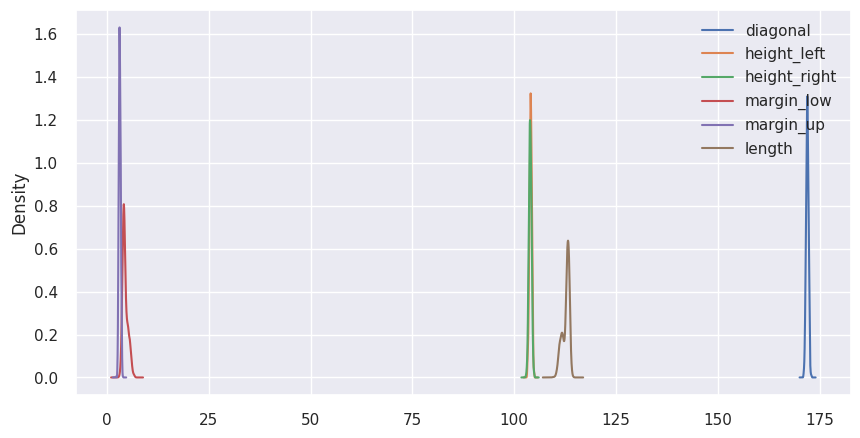

In [30]:
# avant la standardisation
X1 = pd.DataFrame(df,columns=df.columns)
X1.plot(kind='density',sharex=True,figsize=(10,5),layout=(10,1))
plt.show()

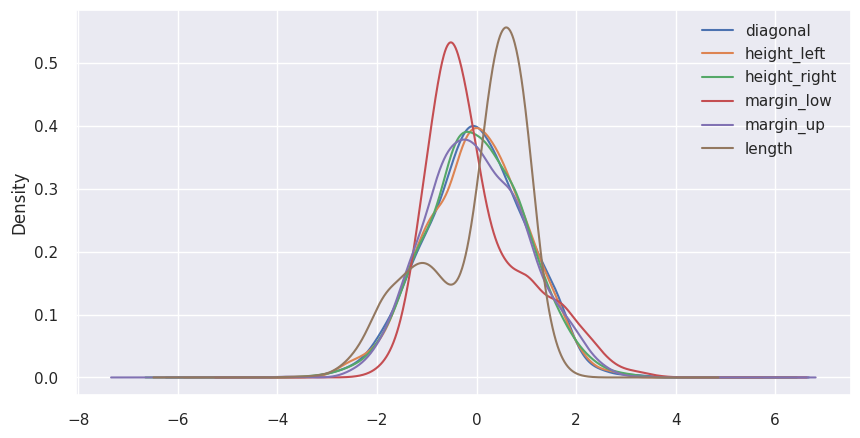

In [31]:
# Apres standardisation
pd.DataFrame(X_scaled,columns=df.columns).plot(kind='density',sharex=True,
                                               figsize=(10,5),layout=(10,1))
plt.show()

In [32]:
pd.DataFrame(X_scaled, index=df.index,columns=df.columns).head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750


**b. Rapport de variance expliqué et scree plot**

In [33]:
# Créer le modèle PCA
model_pca = PCA()

# Ajuster(fit) le modèle aux données
X_reduced = model_pca.fit_transform(X_scaled)

In [34]:
# Rapport de variance expliqué
model_pca.explained_variance_ratio_.round(2)

array([0.43, 0.17, 0.13, 0.12, 0.1 , 0.05])

In [35]:
# Explained variance ratio cumsum
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.43, 0.6 , 0.73, 0.85, 0.95, 1.  ])

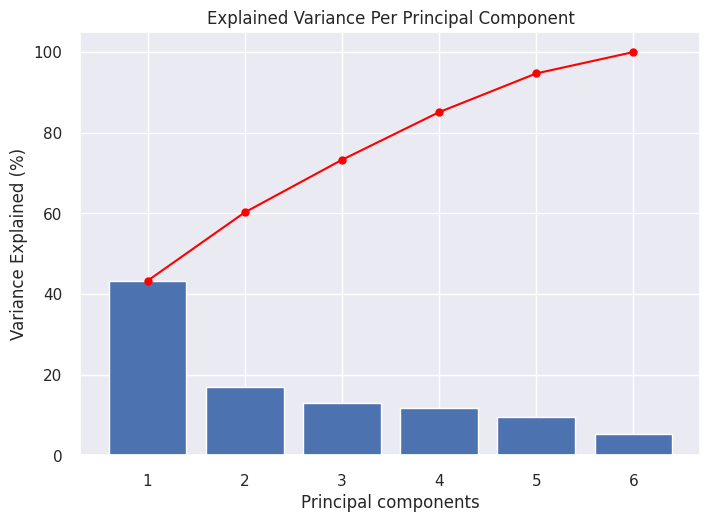

In [36]:
# Scree plot
display_scree_plot(model_pca)

**Notes** :
Nous récupérons 60% d’inertie de la 2ème composante

In [37]:
# Nombre de composantes à étudier
num_components = 2
pcs = model_pca.components_
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]

In [38]:
df.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [39]:
pc1

array([-0.08469767,  0.33063448,  0.39355544,  0.50769282,  0.4394146 ,
       -0.52705225])

In [40]:
pc2

array([ 0.94130387,  0.30752844,  0.10833184, -0.07243963, -0.00495445,
        0.04863598])

**c. Cercles de corrélation et projections de points**

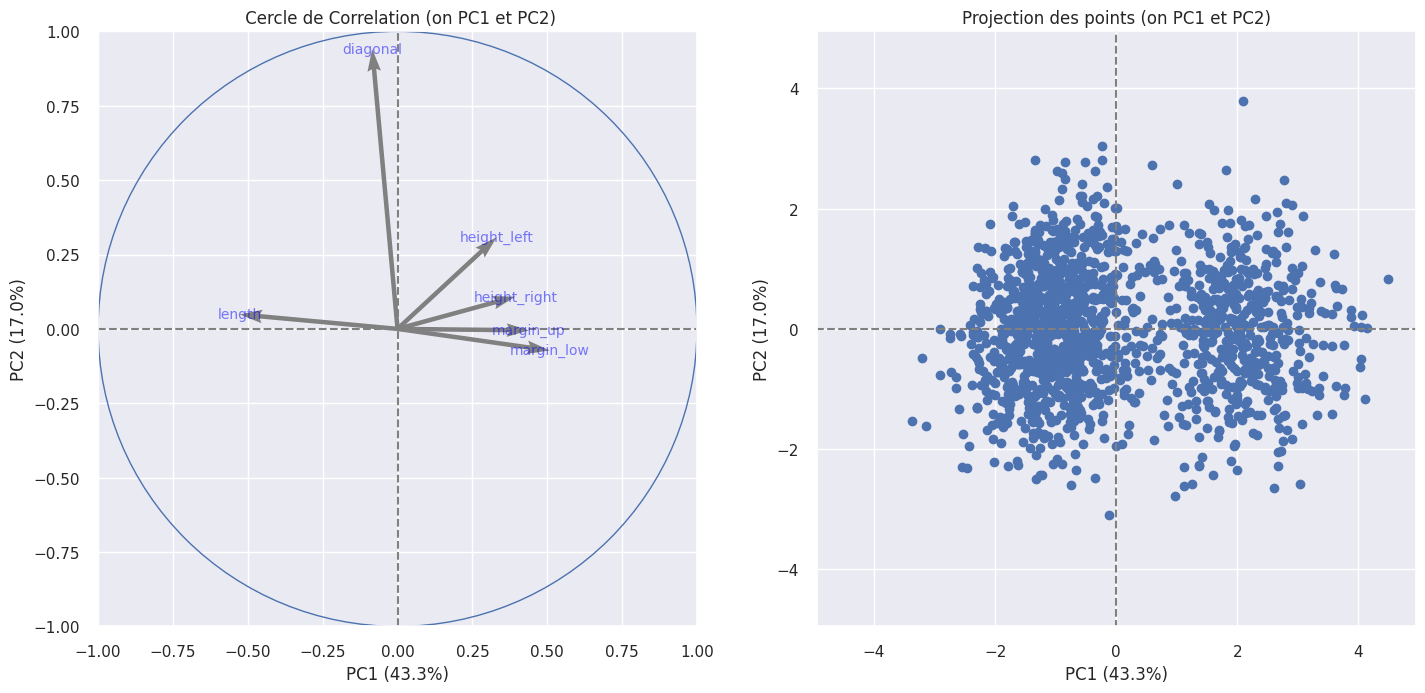

In [41]:
X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)],
                labels = np.array(df.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)])
plt.show()

**Interprétation des axes** :

- PC1 → principalement représentée par les variables « Heigh » (gauche et droite) et « marge » (haut et bas)
- PC2 → principalement représenté par les variables « diagonale » et « hauteur » (gauche et droite

**D. Analyse univariée sur la cible**

In [42]:
target = data[['is_genuine']]

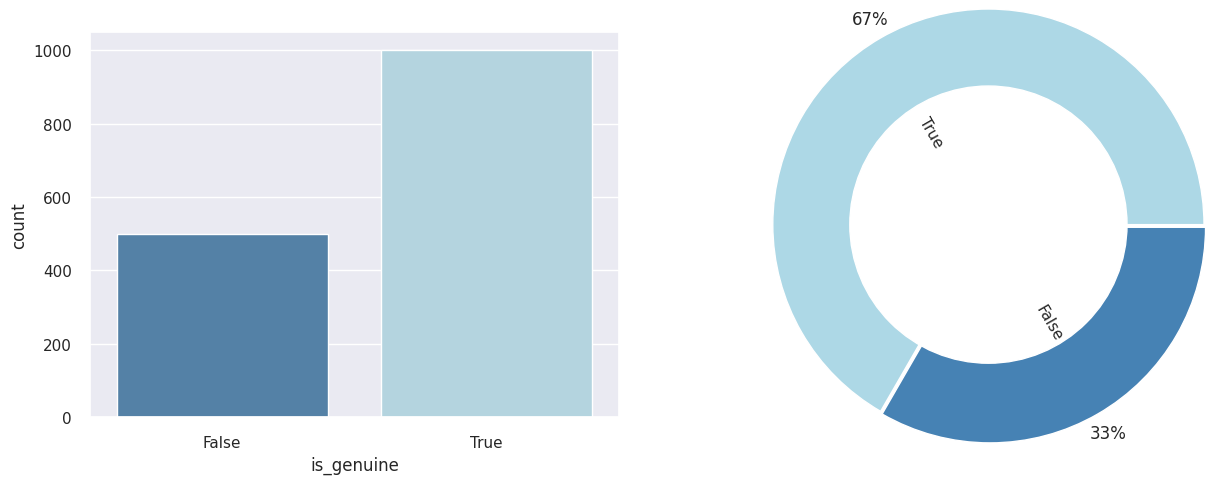

In [43]:
palette =["steelblue","lightblue",]
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x="is_genuine", data=data, palette = palette)
plt.subplot(122)
data["is_genuine"].value_counts().plot(kind="pie", ylabel='',
                                       autopct='%1.0f%%', radius=1.4,
                                       explode = (0, 0.02),
                                       colors=["lightblue","steelblue"],
                                       pctdistance=1.1, labeldistance=0.4,
                                       rotatelabels=True)
circle = plt.Circle( (0,0), 0.9, color='white')
p = plt.gcf()
p.gca().add_artist(circle)

plt.show()

In [44]:
data_arch = data.groupby(by="is_genuine").mean().round(2)
data_arch

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90,104.19,104.14,5.21,3.35,111.63
True,171.99,103.95,103.81,4.12,3.05,113.20


Archétype du faux billet :

- → diagonale 171,90 mm
- height_left → 104,19 mm
- height_right → 104,14 mm
- margin_low → 5,21 mm
- margin_up → 3,35 mm
- longueur → 111,63 mm

Archétype du vrai billet :
- → diagonale 171,99 mm
- height_left → 103,95 mm
- height_right → 103,81 mm
- margin_low → 4,12 mm
- margin_up → 3,05 mm
- longueur → 113,20 mm

→ **En général**, les vrais billets ont une longueur et une diagonale plus élevées, tandis que les variables height_left, height_right, margin_low et margin_up sont plus élevées pour les faux billets


**II. Régression logistique**

➥ Nous avons un ensemble de classes prédéfinies et nous voulons savoir à quelle classe appartient un nouvel objet...

In [45]:
data_reglog = data.copy()

#Définir les valeurs caractéristiques X et la valeur cible Y
x = data_reglog.iloc[:, 1:]
y = data_reglog.iloc[:, 0]

# Fractionnement du jeu de données (0,75/0,25 par défaut)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

# Instanciation du modèle
model_regLog = linear_model.LogisticRegression(random_state = 0,
                solver = 'liblinear', multi_class = 'auto')

# Training
model_regLog.fit(x_train,y_train)

# Taux de précision du modèle
precision_train = model_regLog.score(x_train,y_train)
precision_test = model_regLog.score(x_test,y_test)
print("Taux de précision du modèle d’apprentissage :",round(precision_train*100,2),"%")
print("Taux de précision du modèle de test :",round(precision_test*100,2),"%")

Taux de précision du modèle d’apprentissage : 98.76 %
Taux de précision du modèle de test : 99.2 %


**B. Essais**

In [46]:
# Test1
prediction_test1 = model_regLog.predict([[171.81,104.86,104.95,4.52,2.89,112.83]])
print(prediction_test1[0])

False


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [47]:
# Test 2
prediction_test2 = model_regLog.predict([[171.46,103.36,103.66,3.77,2.99,113.09]])
print(prediction_test2[0]);

True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [48]:
# Predictions
y_pred_test = model_regLog.predict(x_test)

**EVALUATION DU MODEL**

**1.MATRICE DE CONFUSION**

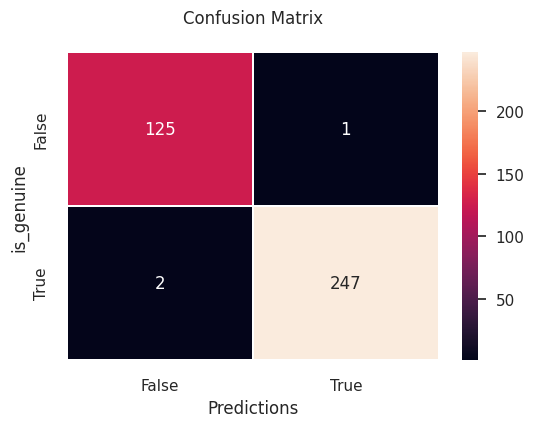

In [49]:
plt.figure(figsize=(6,4))
conf_matrix_reglog = pd.crosstab(y_test, y_pred_test)
sns.heatmap(conf_matrix_reglog, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("Predictions")
plt.title("Confusion Matrix\n")
plt.show()

**note** :
- Sur les 126 faux billets → Nous avons 1 faux négatifs → taux de précision de 99,2%
- Sur les 249 vrais billets → Nous avons 2 faux positifs → taux de précision de 99,2%

**b. Mesure de la qualité de la classification (courbe ROC)**

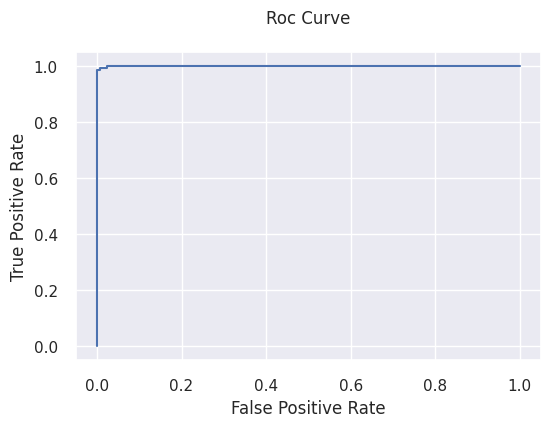

In [50]:
# Definir les metrics
plt.figure(figsize=(6,4))
y_pred_proba = model_regLog.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# courbe de roc
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc Curve\n")
plt.show()

**note** :
L’aire sous la courbe ROC (AUC) est presque égale à 1 → la classification est de très bonne qualité

**c. Optimisation**

**La validation croisée Grid Search** est une technique permettant de sélectionner le meilleur du modèle de machine learning, paramétré par une grille d’hyperparamètres.

In [51]:
grid = {"C":[1, 10, 100, 1000],
         "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
         "penalty":["l1","l2","elasticnet","none"],
         "random_state":[0]}
model_opti = GridSearchCV(model_regLog, grid, cv = 10)
model_opti.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [0],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [52]:
print("Hyperparamètres réglés (meilleurs paramètres) :",model_opti.best_params_)
print("Taux de précision du modèle :",round(model_opti.best_score_*100,2),"%")

Hyperparamètres réglés (meilleurs paramètres) : {'C': 1000, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear'}
Taux de précision du modèle : 98.93 %


- **Evaluation:**

In [53]:
# Predictions
y_pred_test = model_opti.predict(x_test)

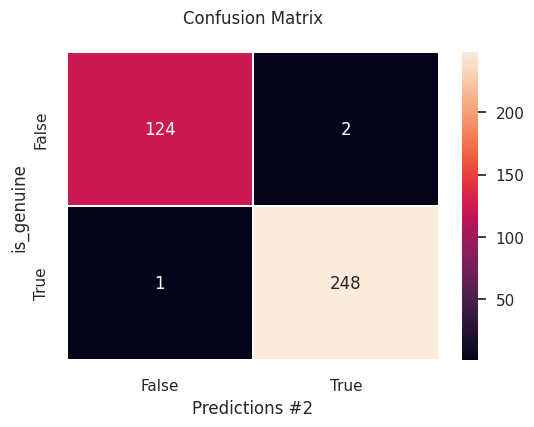

In [54]:
plt.figure(figsize=(6,4))
conf_matrix_reglog2 = pd.crosstab(y_test, y_pred_test)
sns.heatmap(conf_matrix_reglog2, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("Predictions #2")
plt.title("Confusion Matrix\n")
plt.show()

**note** :

- Sur les 126 faux billets → Nous avons 2 faux négatifs → taux
de précision de 98,4%
- Sur les 249 vrais billets → Nous avons 1 faux positifs → taux d’exactitude
de 99,6%
Sélection finale :
* Au vu des résultats (taux de précision) de nos deux modèles, nous sélectionnerons le modèle de régression logistique pour la mise en œuvre de notre fonction de test


**III. Mise en œuvre de la fonction d’essai**

**A. Préparation des échantillons**

In [55]:
# File to test
billets_prod = pd.read_csv("1-billets_production.csv")
display(billets_prod.head())

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


**B. Mise en œuvre de la fonction d’essai**

In [56]:
def fake_detect(data, model_opti):
    x = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]
    prediction = model_opti.predict(x)
    probability = model_opti.predict_proba(x)
    x["proba_false"] = probability[:,0]
    x["proba_true"] = probability[:,1]
    x["prediction"] = prediction
    x_fake_detect = pd.DataFrame(x, index=x.index, columns=x.columns)
    data_fake_detect = data.merge(x_fake_detect)

    print(" "*50,"*"*50,"\n")
    print('\033[1m' + "Nombre total de billets : " +  '\033[0m',len(x))
    print('\033[1m' + "Nombre total de faux billets : " +  '\033[0m',len(x[x["prediction"]== 0]))
    print('\033[1m' + "Nombre total de billets réels : " +  '\033[0m',len(x[x["prediction"]== 1]), "\n")

    display(data_fake_detect)
    print(" "*50,"*"*50,"\n")

**C. RESULTAT DES TEST**

- Test#1

In [58]:
fake_detect(billets_prod,model_opti )

                                                   ************************************************** 

Nombre total de billets :  5
Nombre total de faux billets :  3
Nombre total de billets réels :  2 



,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_false,proba_true,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.999553,0.000447,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.999959,0.000041,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.999954,0.000046,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.026031,0.973969,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.000033,0.999967,True


                                                   ************************************************** 



- **Test#2**

In [59]:
# File to test
final_test = pd.read_csv("final_test.csv")
display(final_test.head())

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [60]:
fake_detect(final_test, model_opti)

                                                   ************************************************** 

Nombre total de billets :  5
Nombre total de faux billets :  3
Nombre total de billets réels :  2 



,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_false,proba_true,prediction
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.001999,0.998001,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.998477,0.001523,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.000143,0.999857,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.999996,0.000004,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.996053,0.003947,False


                                                   ************************************************** 



In [61]:
# enregistrer le modèle
import pickle
pickle.dump(model_opti, open("model_opti.pkl", "wb"))